###  Use API to scrape data from Reddit 


In [1]:
import requests
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import en_core_web_sm
import spacy


from time import sleep
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:
def generate_subreddit(sub_name, time):
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': sub_name,
        'size': 100,
        'before':time
    }
    res = requests.get(url, params)
    return res.json()

In [3]:
time_c = 1594415611
r_data_list = []
mil_data = []
while time_c != 1595279611:
    relation_100 = generate_subreddit('relationships',time_c)['data']
    mil_100 = generate_subreddit('JUSTNOMIL',time_c)['data']
    r_data_list.extend(relation_100)
    mil_data.extend(mil_100)
    time_c += 86400

In [4]:
relationships = pd.DataFrame(r_data_list)

In [5]:
mil = pd.DataFrame(mil_data)

In [6]:
reddit_df = pd.concat([relationships, mil], axis = 0)

In [7]:
reddit_df.reset_index(drop=True, inplace=True)

In [8]:
reddit_df.shape

(2000, 72)

### Pre-Processing

#### Pre-Processing for EDA

filter out stop words

In [9]:
def title_to_words(raw_title):
    #tokenize the title to words
    tokenizer = RegexpTokenizer(r'\w+')
    title_token = tokenizer.tokenize(raw_title.lower())
    
    #stop words 
    stops = set(stopwords.words('english'))
    stop2 = {'mother', 'mom', 'mil', 'fmil', 'relationship', 'wants',
             'get', 'got', 'jnmil', 'one', 'really'}
    stops.update(stop2)
    meaningful_words = [word for word in title_token if word not in stops]
    
    return(" ".join(meaningful_words))
    
    
    

In [10]:
r_titles = reddit_df.loc[reddit_df['subreddit'] == 'relationships', 'title']

In [11]:
relationship_clean = []
for each_title in r_titles:
    relationship_clean.append(title_to_words(each_title))


In [12]:
mil_titles = reddit_df.loc[reddit_df['subreddit'] == 'JUSTNOMIL', 'title']

In [13]:
mil_clean = []
for each_title in mil['title']:
    mil_clean.append(title_to_words(each_title))


### EDA

#### 1. find out the most frequency words for each subreddit
plot the top 10 most frequent words for each subreddit

In [14]:
cvec = CountVectorizer(min_df=2)

In [15]:
relation_cvec = cvec.fit_transform(relationship_clean)

In [16]:
relation_df = pd.DataFrame(relation_cvec.toarray(), columns = cvec.get_feature_names())

In [17]:
relation_df.head()

,10,11,12,1300,15,16,16f,16m,17,17f,...,working,worried,worth,would,wrong,wrongfully,wrote,year,years,younger
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
def word_frequency(df):
    words_freq = [(word, df[word].sum()) for word in df.columns]
    freq_df = pd.DataFrame(sorted(words_freq, 
                                  key = lambda word: word[1], 
                                  reverse = True), columns = ['word', 'count'])
    return freq_df

In [19]:
relation_freq = word_frequency(relation_df).head(15)

Text(0.5, 0, 'Count')

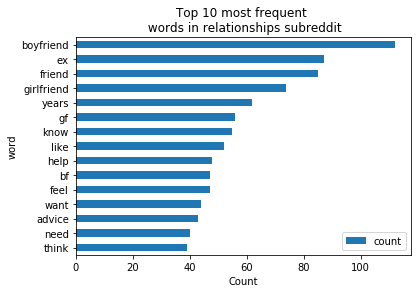

In [20]:
relation_freq.plot(x = 'word', y = 'count', kind ='barh').invert_yaxis()
plt.title('Top 10 most frequent \n words in relationships subreddit')
plt.xlabel('Count')

In [21]:
justnomil_cvec = cvec.fit_transform(mil_clean)

In [22]:
nomil_df = pd.DataFrame(justnomil_cvec.toarray(), 
                        columns = cvec.get_feature_names())

In [23]:
nomil_freq = word_frequency(nomil_df).head(15)

Text(0.5, 0, 'Count')

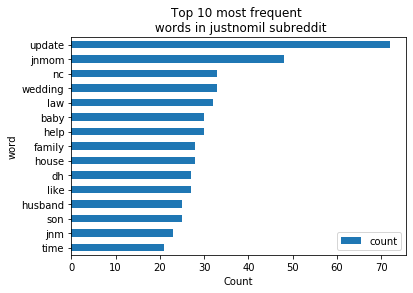

In [24]:
nomil_freq.plot(x = 'word', y = 'count',kind ='barh').invert_yaxis()
plt.title('Top 10 most frequent \n words in justnomil subreddit')
plt.xlabel('Count')

#### 2.   Sentiment analysis with VADER
Average positive, negative plot for each subreddit

In [25]:
sia = SentimentIntensityAnalyzer()

In [26]:
dicts = []
for post in reddit_df['title']:
    scores = sia.polarity_scores(post)
    dicts.append(scores)

scores = pd.DataFrame(dicts)
scores.head()

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.000,0.495,0.505,0.4696
2,0.208,0.463,0.329,0.5574
3,0.268,0.628,0.105,-0.5994
4,0.359,0.641,0.000,-0.4215


In [27]:
vader_df = pd.concat([reddit_df, scores], axis=1)

In [28]:
vader_df.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,preview,edited,gilded,author_flair_template_id,author_cakeday,distinguished,neg,neu,pos,compound
0,[],False,Antiques726,None,[],None,text,t2_6keadnov,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.000,0.0000
1,[],False,ditibi,None,[],None,text,t2_qcjh7,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.495,0.505,0.4696
2,[],False,RedditAccount28,None,[],None,text,t2_hkafz,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.208,0.463,0.329,0.5574
3,[],False,polishedwood2020,None,[],None,text,t2_753k9ekw,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.268,0.628,0.105,-0.5994
4,[],False,aintthatakickintheh,None,[],None,text,t2_78cyg9v9,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,0.359,0.641,0.000,-0.4215


In [29]:
pos_neg = vader_df.groupby('subreddit').mean()[['pos', 'neg']]

In [30]:
colors = pos_neg.columns.map({'pos': '#F4A460', 'neg': '#483D8B'})

Text(0.5, 1.0, 'Sentiment Analysis with VADER')

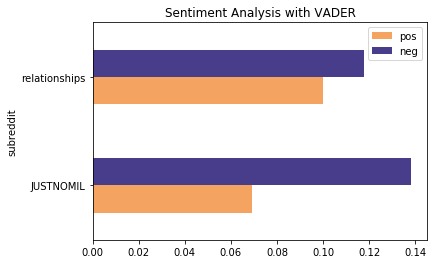

In [31]:
vader_df.groupby('subreddit').mean()[['pos', 'neg']].plot(kind = 'barh', color = colors)
plt.title('Sentiment Analysis with VADER')

Ref: https://git.generalassemb.ly/Icebear/nlp_modeling_and_sentiment_analysis/blob/master/sia-solutions.ipynb

#### 3.   Similarity between the two subreddits 


In [32]:
def average_sim (n):
    relation_string = [i for i in r_titles][n]
    relation_string = relation_string.replace('(', '').replace(')', '').replace('.', '')
    mil_string = [i for i in mil_titles][n]
    mil_string = mil_string.replace('(', '').replace(')', '').replace('.', '')
    
    nlp = spacy.load("en_core_web_sm")
    score = []
    relation_token = nlp(relation_string)
    mil_token = nlp(mil_string)
    for word_r in relation_token:
        for word_mil in mil_token:
            score.append([word_r.text, word_mil.text, word_r.similarity(word_mil)])
    
    return pd.DataFrame(score)[2].mean()

In [33]:
title_n = [0, 1, 2, 3, 4, 5]

In [34]:
%%capture
sim_score_df = pd.DataFrame({
    'title_num': ['title0', 'title1', 'title2', 'title3', 'title4', 'title5'],
    'similarity_score':[average_sim(i) for i in title_n]})

Text(0.5, 1.0, 'Similarity Scores Between \n Post Titles of Each Subreddit')

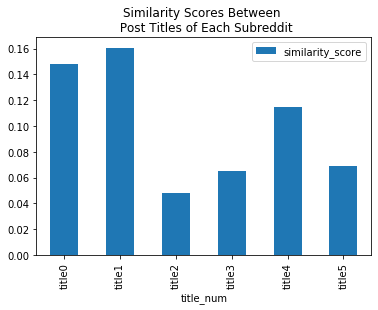

In [35]:
sim_score_df.plot(x = 'title_num', y = 'similarity_score', kind='bar')
plt.title("Similarity Scores Between \n Post Titles of Each Subreddit")

In [36]:
%%capture
total_sim = pd.DataFrame({'scores':[average_sim(i) for i in range(100)] })

In [37]:
total_sim.mean()

scores    0.081468
dtype: float64

ref: https://spacy.io/usage/spacy-101

### Modeling

In [38]:
reddit_df['subreddit'] = reddit_df['subreddit'].map({'relationships': 0, 'JUSTNOMIL': 1})

In [39]:
X = reddit_df['title']
y = reddit_df['subreddit']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [41]:
clean_train = []
clean_test = []
for each_title in X_train:
    clean_train.append(title_to_words(each_title))
    
for each_title in X_test:
    clean_test.append(title_to_words(each_title))

####  Use CountVectorizer to transform the data and MultinomialNB as the model

In [42]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [43]:
pipe_params = {
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [None, 'english']
}

In [44]:
gs = GridSearchCV(pipe, pipe_params, cv = 5)

In [45]:
gs.fit(X_train, y_train);

In [46]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [47]:
gs.score(X_train, y_train)

0.9326666666666666

In [48]:
gs.score(X_test, y_test)

0.894

In [49]:
cvec_preds = gs.predict(X_test)

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, cvec_preds).ravel()

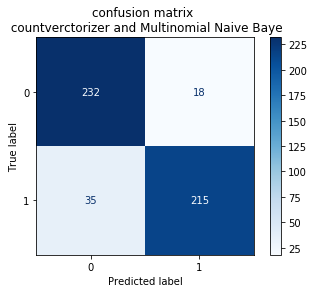

In [51]:
plot_confusion_matrix(gs, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.title('confusion matrix \n countverctorizer and Multinomial Naive Baye');

In [52]:
specificity_cvec = tn / (tn + fp)

In [53]:
specificity_cvec

0.928

In [54]:
sensitivity = tp / (tp + fn)
sensitivity

0.86

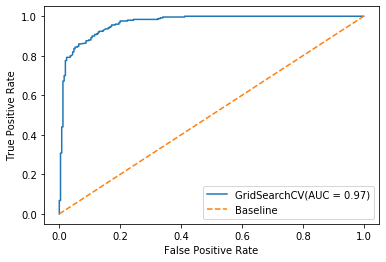

In [55]:
plot_roc_curve(gs,X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.legend(('GridSearchCV(AUC = 0.97)','Baseline'))

#### Use TfidfVectorizer to transform the data and MultinomialNB as the model¶

In [56]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [57]:
pipe_params = {
    'tvec__max_features': [1000,2000, 3000, 4000],
    'tvec__min_df': [2, 3],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__stop_words': [None, 'english']
}

In [58]:
gs_tvec = GridSearchCV(pipe_tvec, pipe_params, cv = 5)

In [59]:
gs_tvec.fit(X_train, y_train);

In [60]:
gs_tvec.best_params_

{'tvec__max_features': 2000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

In [61]:
gs_tvec.score(X_train, y_train)

0.9393333333333334

In [62]:
gs_tvec.score(X_test, y_test)

0.888

In [63]:
tvec_pred = gs_tvec.predict(X_test)

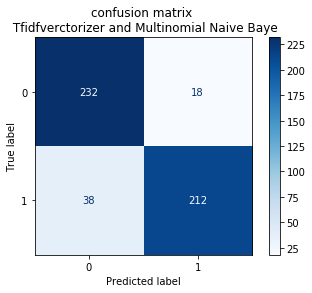

In [64]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.title('confusion matrix \n Tfidfverctorizer and Multinomial Naive Baye');

In [65]:
tn, fp, fn, tp = confusion_matrix(y_test, tvec_pred).ravel()

In [66]:
specificity_tvec = tn / (tn + fp)
specificity_tvec

0.928

In [67]:
sensitivity_tvec = tp / (tp + fn)
sensitivity_tvec

0.848

Text(0.5, 1.0, 'ROC Graph - Tfidfverctorizer and Multinomial Naive Baye')

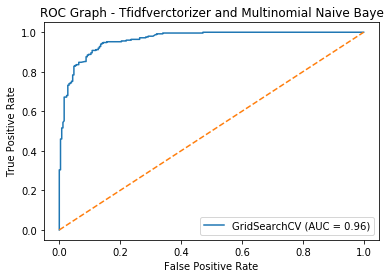

In [68]:
plot_roc_curve(gs_tvec,X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('ROC Graph - Tfidfverctorizer and Multinomial Naive Baye')

#### CountVectorizer and Logistic Regression with Ridge

In [69]:
pipe_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [70]:
pipe_params = {
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [None, 'english'],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear'],
    'lr__C': [ 0.1, 1]
}

In [71]:
gs_cv_lr = GridSearchCV(pipe_lr, pipe_params, cv = 5)

In [72]:
gs_cv_lr.fit(X_train, y_train);

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [73]:
pd.DataFrame(zip(gs_cv_lr.best_estimator_['cvec'].get_feature_names(), 
                 gs_cv_lr.best_estimator_['lr'].coef_[0])).sort_values(by=1)

,0,1
2999,relationship,-1.665750
1373,friend,-1.642734
1472,girlfriend,-1.488195
1451,gf,-1.391012
1163,ex,-1.306749
...,...,...
2572,nc,1.571496
1978,jnmil,1.933718
1988,jnmom,1.939461
2411,mother,2.005064


In [74]:
gs_cv_lr.best_params_

{'cvec__max_df': 0.9,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'lr__C': 1,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear'}

In [75]:
gs_cv_lr.score(X_train, y_train)

0.988

In [76]:
gs_cv_lr.score(X_test, y_test)

0.904

In [77]:
logreg_preds = gs_cv_lr.predict(X_test)

In [78]:
tn, fp, fn, tp = confusion_matrix(y_test, logreg_preds).ravel()

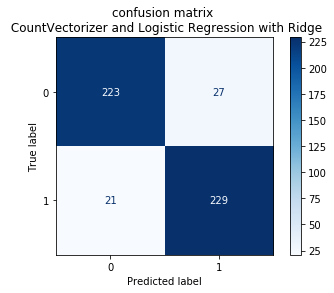

In [79]:
plot_confusion_matrix(gs_cv_lr, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.title('confusion matrix \n CountVectorizer and Logistic Regression with Ridge');

In [80]:
specificity_logreg = tn / (tn + fp)

In [81]:
specificity_logreg

0.892

In [82]:
sensitivity_logreg = tp / (tp + fn)
sensitivity_logreg

0.916

Text(0.5, 1.0, 'ROC - CountVectorizer and Logistic Regression with Ridge')

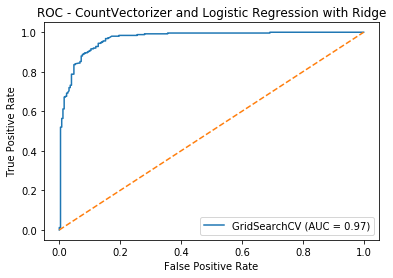

In [83]:
plot_roc_curve(gs_cv_lr,X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('ROC - CountVectorizer and Logistic Regression with Ridge')

In [84]:
pred_proba = [i[1] for i in gs_cv_lr.predict_proba(X_test)]

In [85]:
pred_df =pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

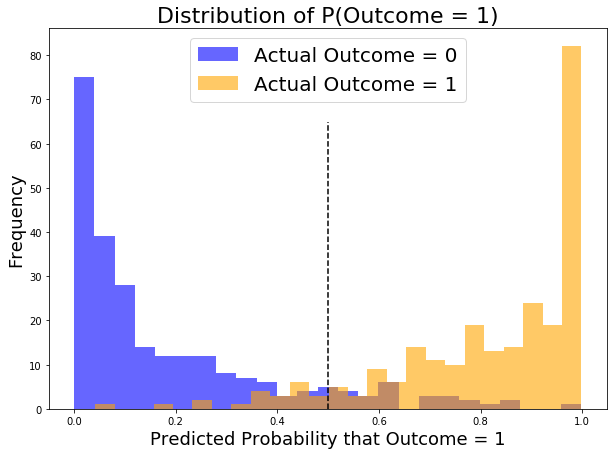

In [86]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Actual Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='black',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

Ref: Noelle's lesson https://git.generalassemb.ly/DSI-US-12/4.05-lesson-classification-metrics-ii/blob/master/starter-code-ec.ipynb

#### RandomForest 

In [87]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [88]:
rf_params = {
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [None, 'english'],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3],
}

In [89]:
gs_rf = GridSearchCV(pipe_rf, rf_params, cv =5)

In [90]:
gs_rf.fit(X_train, y_train);

In [91]:
gs_rf.best_params_

{'cvec__max_df': 0.9,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'rf__max_depth': None,
 'rf__n_estimators': 200}

In [92]:
gs_rf.score(X_train, y_train)

0.9973333333333333

In [93]:
gs_rf.score(X_test, y_test)

0.914

Text(0.5, 1.0, 'ROC Graph - Countvectorizer and Random Forest')

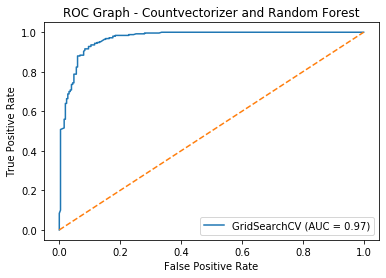

In [94]:
plot_roc_curve(gs_rf,X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('ROC Graph - Countvectorizer and Random Forest')

In [95]:
rf_pred = gs_rf.predict(X_test)

In [96]:
tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()

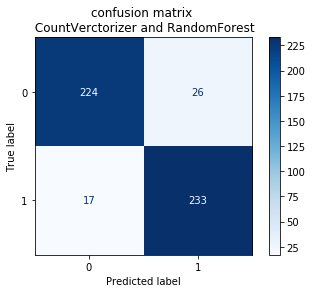

In [97]:
plot_confusion_matrix(gs_rf, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.title('confusion matrix \n CountVerctorizer and RandomForest');

In [98]:
specificity_rf = tn / (tn + fp)
specificity_rf

0.896

In [99]:
sensitivity_rf = tp / (tp + fn)
sensitivity_rf

0.932

#### Bagging 

In [100]:
pipe_bag = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier() )
])

In [101]:
bag_params = {
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [None, 'english'],
    'bag__n_estimators': [25, 50, 100],
    'bag__random_state' :[42]
}

In [102]:
gs_bag = GridSearchCV(pipe_bag, bag_params, cv =5)

In [107]:
gs_bag.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bag', BaggingClassifier())]),
             param_grid={'bag__n_estimators': [25, 50, 100],
                         'bag__random_state': [42], 'cvec__max_df': [0.9, 0.95],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english']})

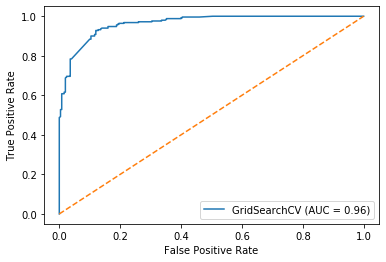

In [108]:
plot_roc_curve(gs_bag,X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')

In [109]:
bag_pred = gs_bag.predict(X_test)

In [110]:
tn, fp, fn, tp = confusion_matrix(y_test, bag_pred).ravel()

In [111]:
specificity_bag = tn / (tn + fp)
specificity_bag

0.864

In [112]:
sensitivity_bag = tp / (tp + fn)
sensitivity_bag

0.936